# Classification: Stock Market example

### Imports y config básica

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

np.random.seed(42)
plt.rcParams["font.size"] = 12

### Cargar datos: smarket

In [ ]:
# Ajusta la ruta si lo tienes en otra carpeta
data = pd.read_csv("data/Smarket.csv")

data.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


> ### 💡 Explicación dato
> 
>  - Year: año de observacion
>  - Lag1-Lag5: Rendimientos mercado en los 5 dias previos
>  - Volume: Actividad del mercado
>  - Today: Rendimiento del mercado hoy
>  - Direction: Si el mercado subió o bajó hoy

### Exploración rápida de datos de mercado

In [ ]:
print("Dimensiones del dataset:", data.shape)
print("\nResumen estadístico:")
display(data.describe())

print("\nDistribución de la variable objetivo (Direction):")
print(data["Direction"].value_counts())


Dimensiones del dataset: (1250, 9)

Resumen estadístico:


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000



Distribución de la variable objetivo (Direction):
Direction
Up      648
Down    602
Name: count, dtype: int64


### Gráfico exploratorio: Scatter Lag1 vs Lag2

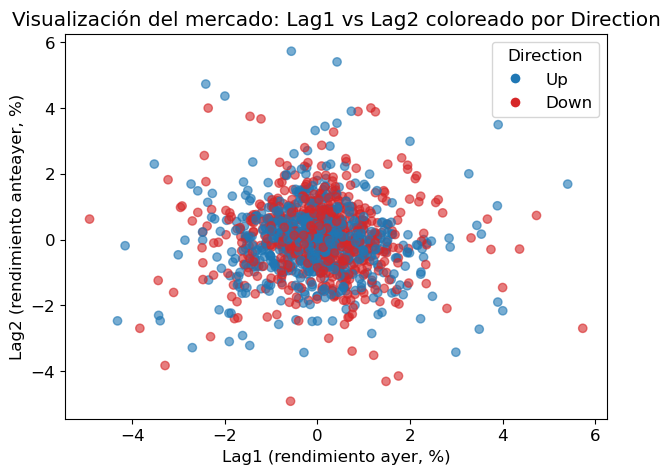

In [ ]:
# Scatter plot Lag1 vs Lag2
fig, ax = plt.subplots(figsize=(7, 5))

# Colores según Direction
colors = data["Direction"].map({"Up": "tab:blue", "Down": "tab:red"})

ax.scatter(data["Lag1"], data["Lag2"], c=colors, alpha=0.6)

ax.set_xlabel("Lag1 (rendimiento ayer, %)")
ax.set_ylabel("Lag2 (rendimiento anteayer, %)")
ax.set_title("Visualización del mercado: Lag1 vs Lag2 coloreado por Direction")

# Crear leyenda manual
from matplotlib.lines import Line2D

legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Up",
        markerfacecolor="tab:blue",
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Down",
        markerfacecolor="tab:red",
        markersize=8,
    ),
]
ax.legend(handles=legend_elements, title="Direction")
plt.show()


> ### 💡 Explicación gráfico
> 
>  - Cada punto es un día del mercado 
>  - Eje X y Eje Y son los rendimientos d eayer y anteayer
>  - El color indica si el mercado subió ese día o bajó
>  - Las clases están mezcladas: no hay una separación simple
> 
> ### 💡 Preguntas
> 
>   - ¿Como funcionarán los modelos lineales como la regresión logística o LDA? ¿y QDA? 

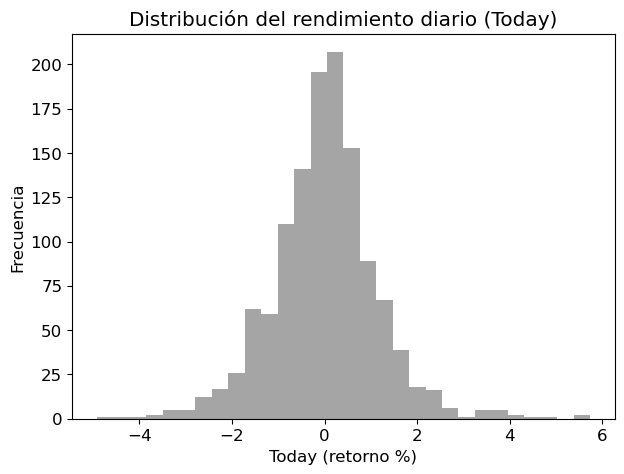

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(data["Today"], bins=30, alpha=0.7, color="tab:gray")
ax.set_xlabel("Today (retorno %)")
ax.set_ylabel("Frecuencia")
ax.set_title("Distribución del rendimiento diario (Today)")
plt.show()

> ### 💡 Explicación gráfico
>
> - La mayoría de días el mercado se mueve entre -2% y +2%. Esto explica por qué Up/Downn son difícies de predecir: el movimiento real es pequeño y ruidoso

### Seleccionar variables y crear train / test

Para que podamos dibujar fronteras de decisión, usaremos solo 2 predictores: Lag1 y Lag2.

In [41]:
# Predictores: Lag1 y Lag2
X = data[["Lag1", "Lag2"]].values

# Variable objetivo: Direction (Up/Down)
y = data["Direction"].values

# Codificar Up/Down a 0/1
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Up/Down -> 0/1 (el orden lo da el encoder)

print("Clases codificadas:", dict(zip(le.classes_, le.transform(le.classes_))))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

len(X_train), len(X_test)


Clases codificadas: {'Down': np.int64(0), 'Up': np.int64(1)}


(875, 375)

### Ajustar modelos: logística, LDA, QDA

In [ ]:
# 1. Regresión logística
log_reg = LogisticRegression(
    solver="liblinear"
)  # solver simple para binario --> algoritmo que realiza la optimización iterativa (RL maximiza la verosimilitud/minimiza pérdida))-liblinear es estable y rapido para RL con datasets pequeños/medianos
log_reg.fit(X_train, y_train)

# 2. LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# 3. QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

# Predicciones
y_pred_log = log_reg.predict(X_test)
y_pred_lda = lda.predict(X_test)
y_pred_qda = qda.predict(X_test)

# Accuracy
acc_log = accuracy_score(y_test, y_pred_log)
acc_lda = accuracy_score(y_test, y_pred_lda)
acc_qda = accuracy_score(y_test, y_pred_qda)

print(f"Accuracy test - Regresión logística: {acc_log:.3f}")
print(f"Accuracy test - LDA:                 {acc_lda:.3f}")
print(f"Accuracy test - QDA:                 {acc_qda:.3f}")


Accuracy test - Regresión logística: 0.509
Accuracy test - LDA:                 0.509
Accuracy test - QDA:                 0.517


> ### 💡 Explicación resultado
> 
>  - Todos intentan resolver el mismo problema: Up vs Down.
> - Accuracy --> tasa acierto = Nºpred_correctas/Nºtotal_pred
>  - Las diferencias en accuracy no suelen ser gigantes, pero sí ilustrativas.
> 
> 

### Matrices de confusión y classification report

In [ ]:
models = {"Logistic": y_pred_log, "LDA": y_pred_lda, "QDA": y_pred_qda}

for name, y_pred in models.items():
    print(f"\n=== {name} ===")
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de confusión:")
    print(cm)
    print("\nInforme de clasificación:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))



=== Logistic ===
Matriz de confusión:
[[ 53 128]
 [ 56 138]]

Informe de clasificación:
              precision    recall  f1-score   support

        Down       0.49      0.29      0.37       181
          Up       0.52      0.71      0.60       194

    accuracy                           0.51       375
   macro avg       0.50      0.50      0.48       375
weighted avg       0.50      0.51      0.49       375


=== LDA ===
Matriz de confusión:
[[ 53 128]
 [ 56 138]]

Informe de clasificación:
              precision    recall  f1-score   support

        Down       0.49      0.29      0.37       181
          Up       0.52      0.71      0.60       194

    accuracy                           0.51       375
   macro avg       0.50      0.50      0.48       375
weighted avg       0.50      0.51      0.49       375


=== QDA ===
Matriz de confusión:
[[ 42 139]
 [ 42 152]]

Informe de clasificación:
              precision    recall  f1-score   support

        Down       0.50      0.23 

> ### 💡 Explicación 
> Interpretación Matriz de Confusión
> |               | Predicho Down | Predicho Up  |
> |---------------|---------------|--------------|
> | **Real Down** | TN            | FP           |
> | **Real Up**   | FN            | TP           |
>
> Otros parámetros:
> - **Precision**: mide valor predictivo ¿De todos los que predigo como esta clase, cuántos son correctos?
> - **Recall**: mide sensibilidad ¿De toos los datos reales de esta clase, cuantos detecto?
> - **F1-score**: media armónica entre precisión y recall 
> - **macro avg**: Media simple de cada clase (todas las clases pesan igual)
> - **weighted avg**: media ponderada por nº casos (las clases grandes pesan más)

### Ploteamos las fronteras de decisión en 2D (Lag1 vs Lag2)

Esta celda es visual para ver cómo se comportan las fronteras de los tres modelos en el espacio (Lag1, Lag2).

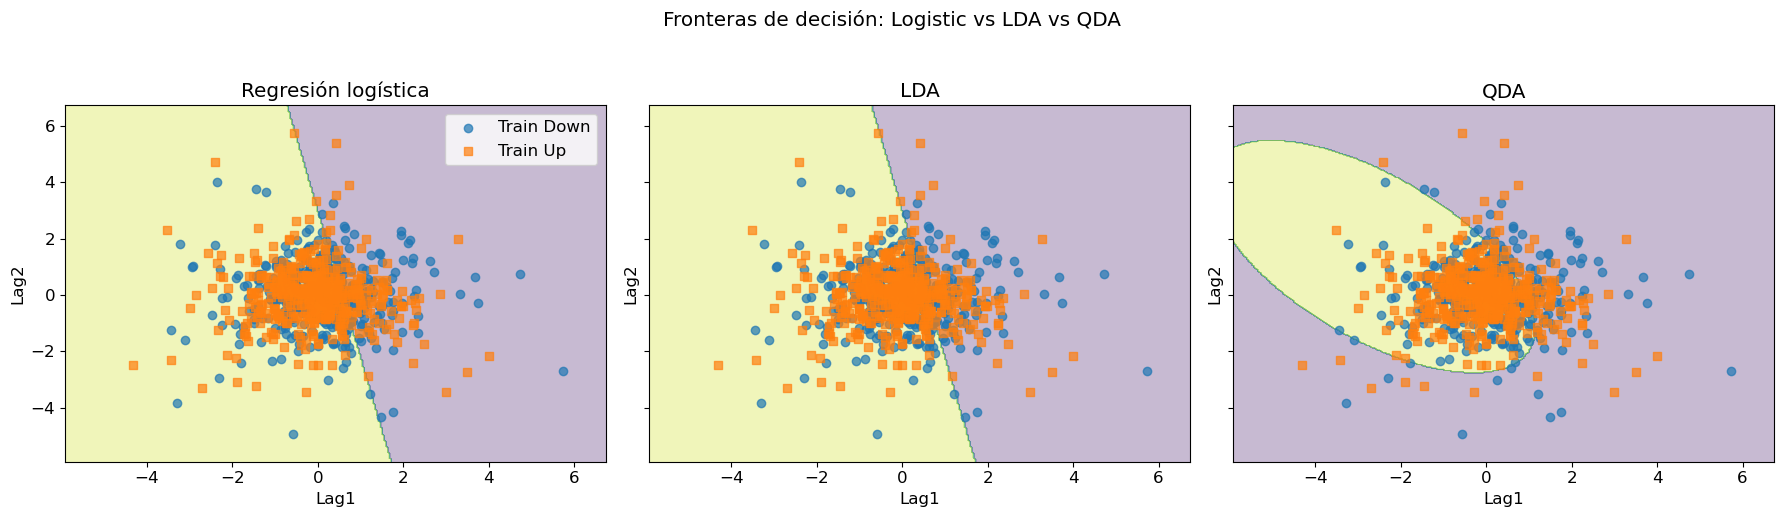

In [ ]:
# Crear una malla (grid) para dibujar las fronteras
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

grid = np.c_[xx.ravel(), yy.ravel()]

# Predicción de cada modelo en la malla
Z_log = log_reg.predict(grid).reshape(xx.shape)
Z_lda = lda.predict(grid).reshape(xx.shape)
Z_qda = qda.predict(grid).reshape(xx.shape)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

titles = ["Regresión logística", "LDA", "QDA"]
Zs = [Z_log, Z_lda, Z_qda]

for ax, Z, title in zip(axes, Zs, titles):
    # Dibujar región de decisión
    ax.contourf(xx, yy, Z, alpha=0.3)

    # Puntos de entrenamiento
    # Up = y=clase que corresponda en le.classes_
    # Vamos a separarlos por clase
    for class_value, class_name, marker in zip([0, 1], le.classes_, ["o", "s"]):
        idx = y_train == class_value
        ax.scatter(
            X_train[idx, 0],
            X_train[idx, 1],
            alpha=0.7,
            label=f"Train {class_name}" if ax is axes[0] else None,
            marker=marker,
        )

    ax.set_title(title)
    ax.set_xlabel("Lag1")
    ax.set_ylabel("Lag2")

axes[0].legend(loc="upper right")
plt.suptitle("Fronteras de decisión: Logistic vs LDA vs QDA", y=1.03)
plt.tight_layout()
plt.show()

> ### 💡 Explicación 
>
> - RL y LDA --> fronteras lineales 
> - QDA --> frontera curva, máx flexible